# XYZ转规则格网（重采样）

SMAP的L2分发的数据是一维向量，并非二维网格，裁剪制图等分析不方便。但给出了每个元素的经纬度坐标，这就创造了向等经维度网格重采样的条件（也可以认为是重投影了）

## 数据读取

In [197]:
import h5py
import pandas as pd
import numpy as np

smap_l2_smp = "/home/xueke/Datasets/RS/SMAP_L2_SMP/SMAP_L2_SM_P_07128_D_20160601T230236_R18290_001.h5"
smp_obj = h5py.File(smap_l2_smp)
lon = smp_obj["Soil_Moisture_Retrieval_Data/longitude"][:]
lat = smp_obj["Soil_Moisture_Retrieval_Data/latitude"][:]
sm = smp_obj["Soil_Moisture_Retrieval_Data/soil_moisture"][:]

smp_obj.close()

# 只要sm大于0.02的且小于0.5的点（移除无效值点）
ds = pd.DataFrame({"lon":lon, "lat":lat, "sm":sm}).query("sm>=0.02 & sm<=0.5")

## GMT方案

gmt是一个命令行程序，但这里运行不了bash脚本，那就用GMT的Python接口了

将离散的xyz数据，采用最近邻域法，重采样到网格大小为0.36度X0.36度，经度区域为-180度到180度，纬度区域为-90度到90度的网格中，邻域的搜索半径为0.5度。

当然，这个region可以设置为任何感兴趣区域，这里为了方便展示，用了全球范围。

### 先什么都不干，单画散点图来看看数据的分布

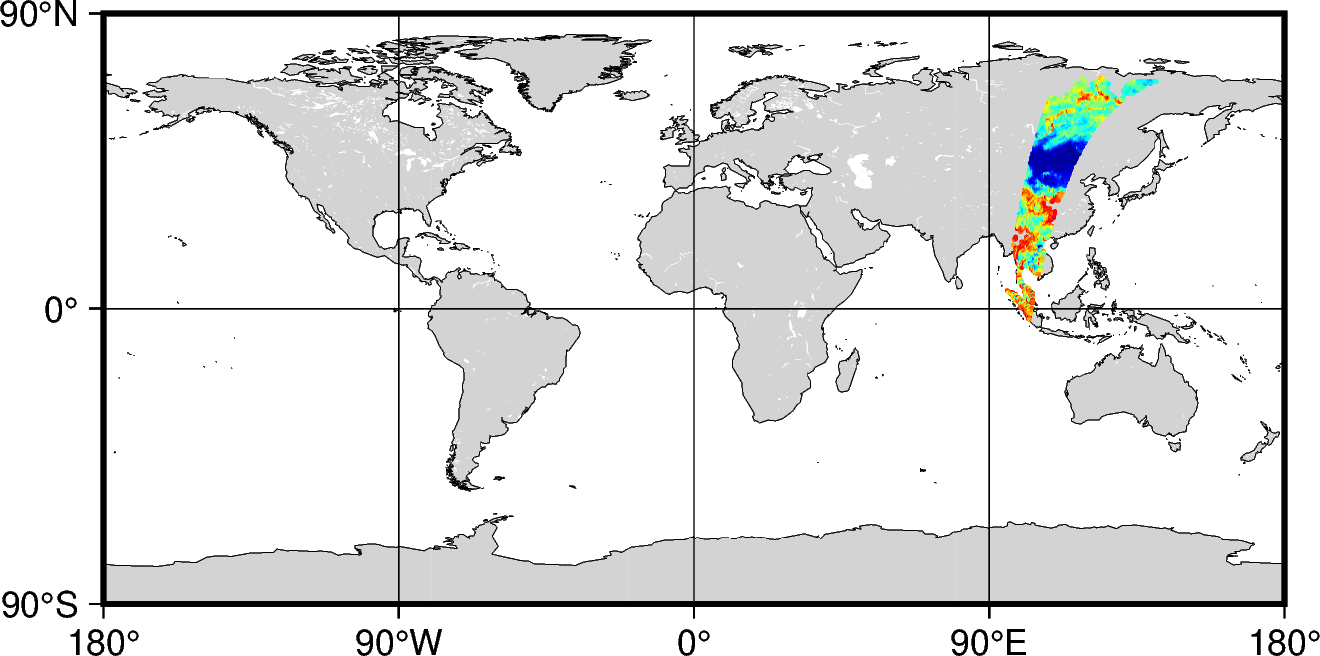

In [263]:
fig = pygmt.Figure()
pygmt.config(MAP_FRAME_TYPE="plain")
# 创建色标，范围是0到0.6，分度是0.01
pygmt.makecpt(cmap="jet", series="0/0.55/0.01")
# 在gmt中，对于region来说，region='d'等价于region='-180/180/-90/90'    
fig.coast(region='d', projection="Q10c", land="lightgray", water="white", shorelines="1/0.1p")
fig.plot(x=ds["lon"], y=ds["lat"], fill=ds["sm"], frame="ag", style="c1p", cmap=True)
fig.show()

### 太小了看不清，把画布放大一点！

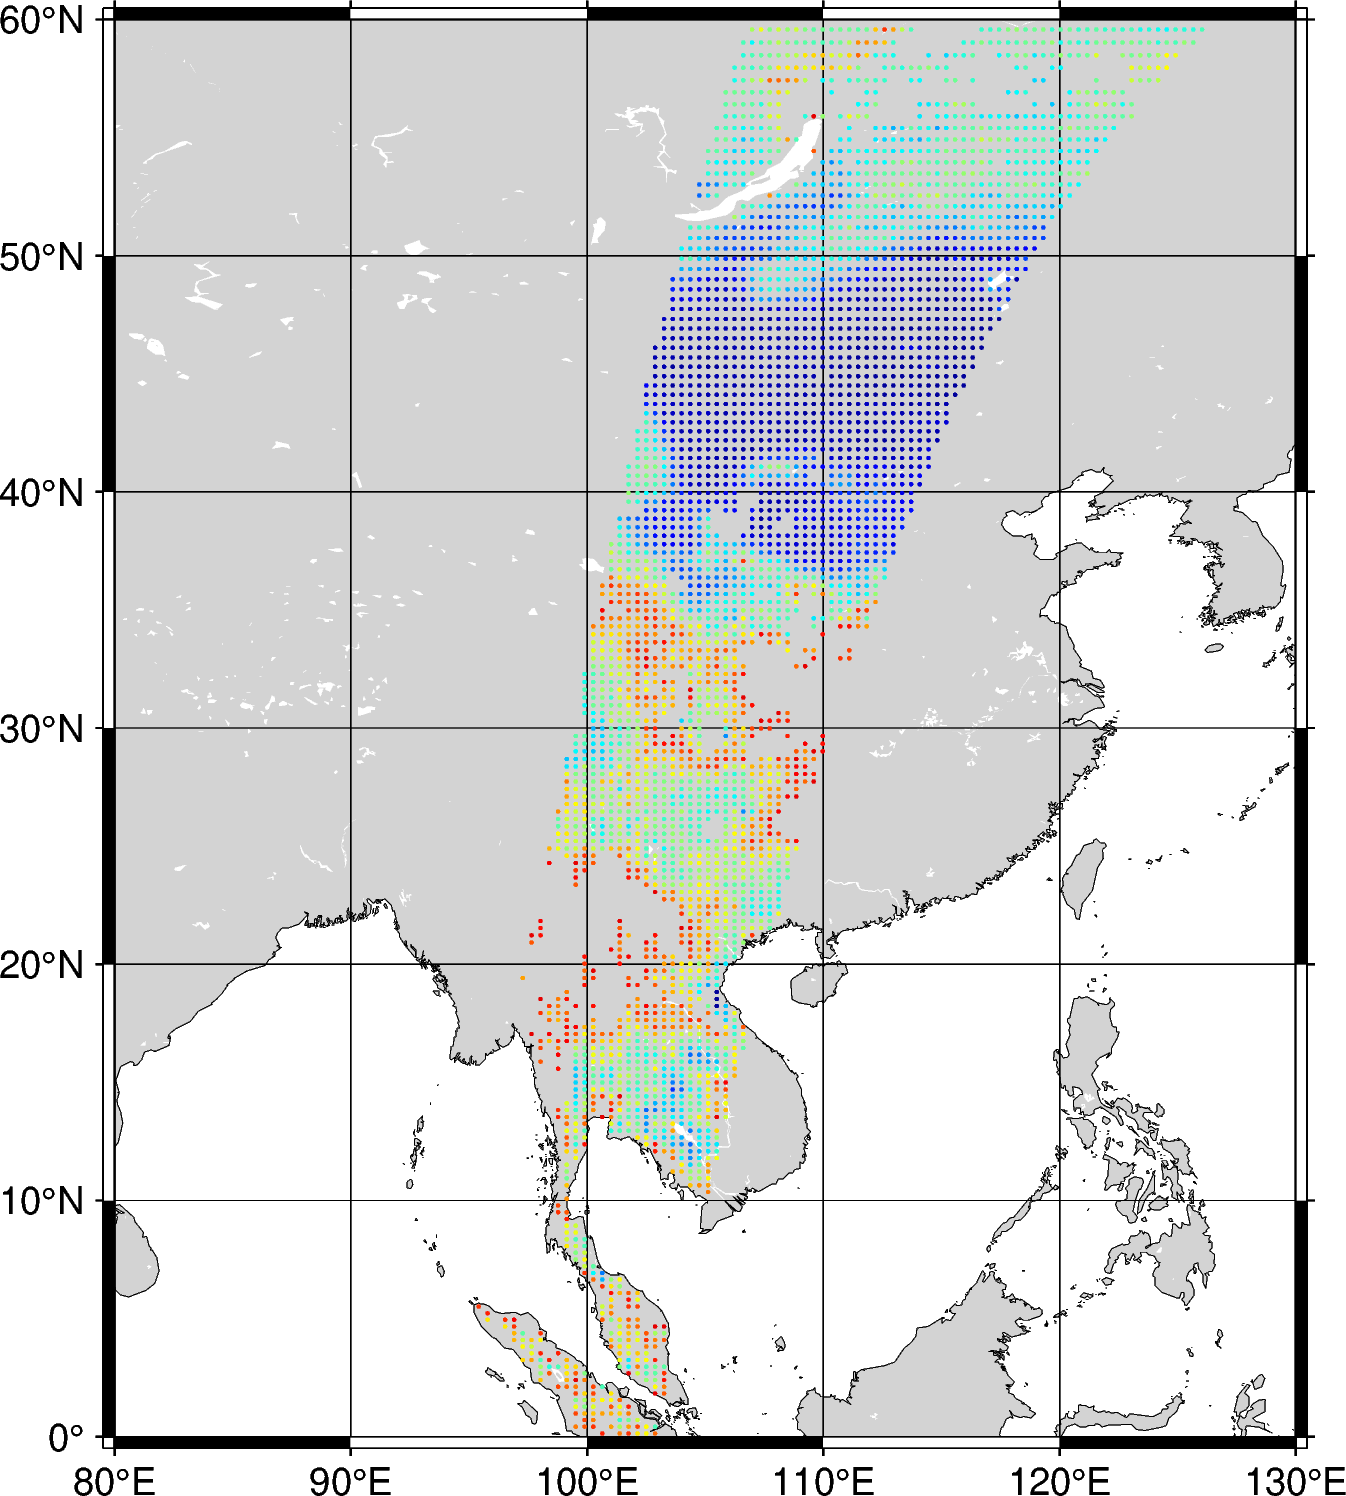

In [267]:
fig = pygmt.Figure()
pygmt.makecpt(cmap="jet", series="0/0.55/0.01")
fig.coast(region='80/130/0/60', projection="Q10c", land="lightgray", water="white", shorelines="1/0.1p")
fig.plot(x=ds["lon"], y=ds["lat"], fill=ds["sm"], frame="ag", style="c1p", cmap=True)
fig.show()

### 好了，执行网格化吧！

In [265]:
import pygmt
grid_sm = pygmt.nearneighbor(x=ds["lon"], y=ds["lat"], z=ds["sm"], spacing="0.36d/0.36d", region='d', search_radius="0.7d")

### 网格化后的数据什么样？

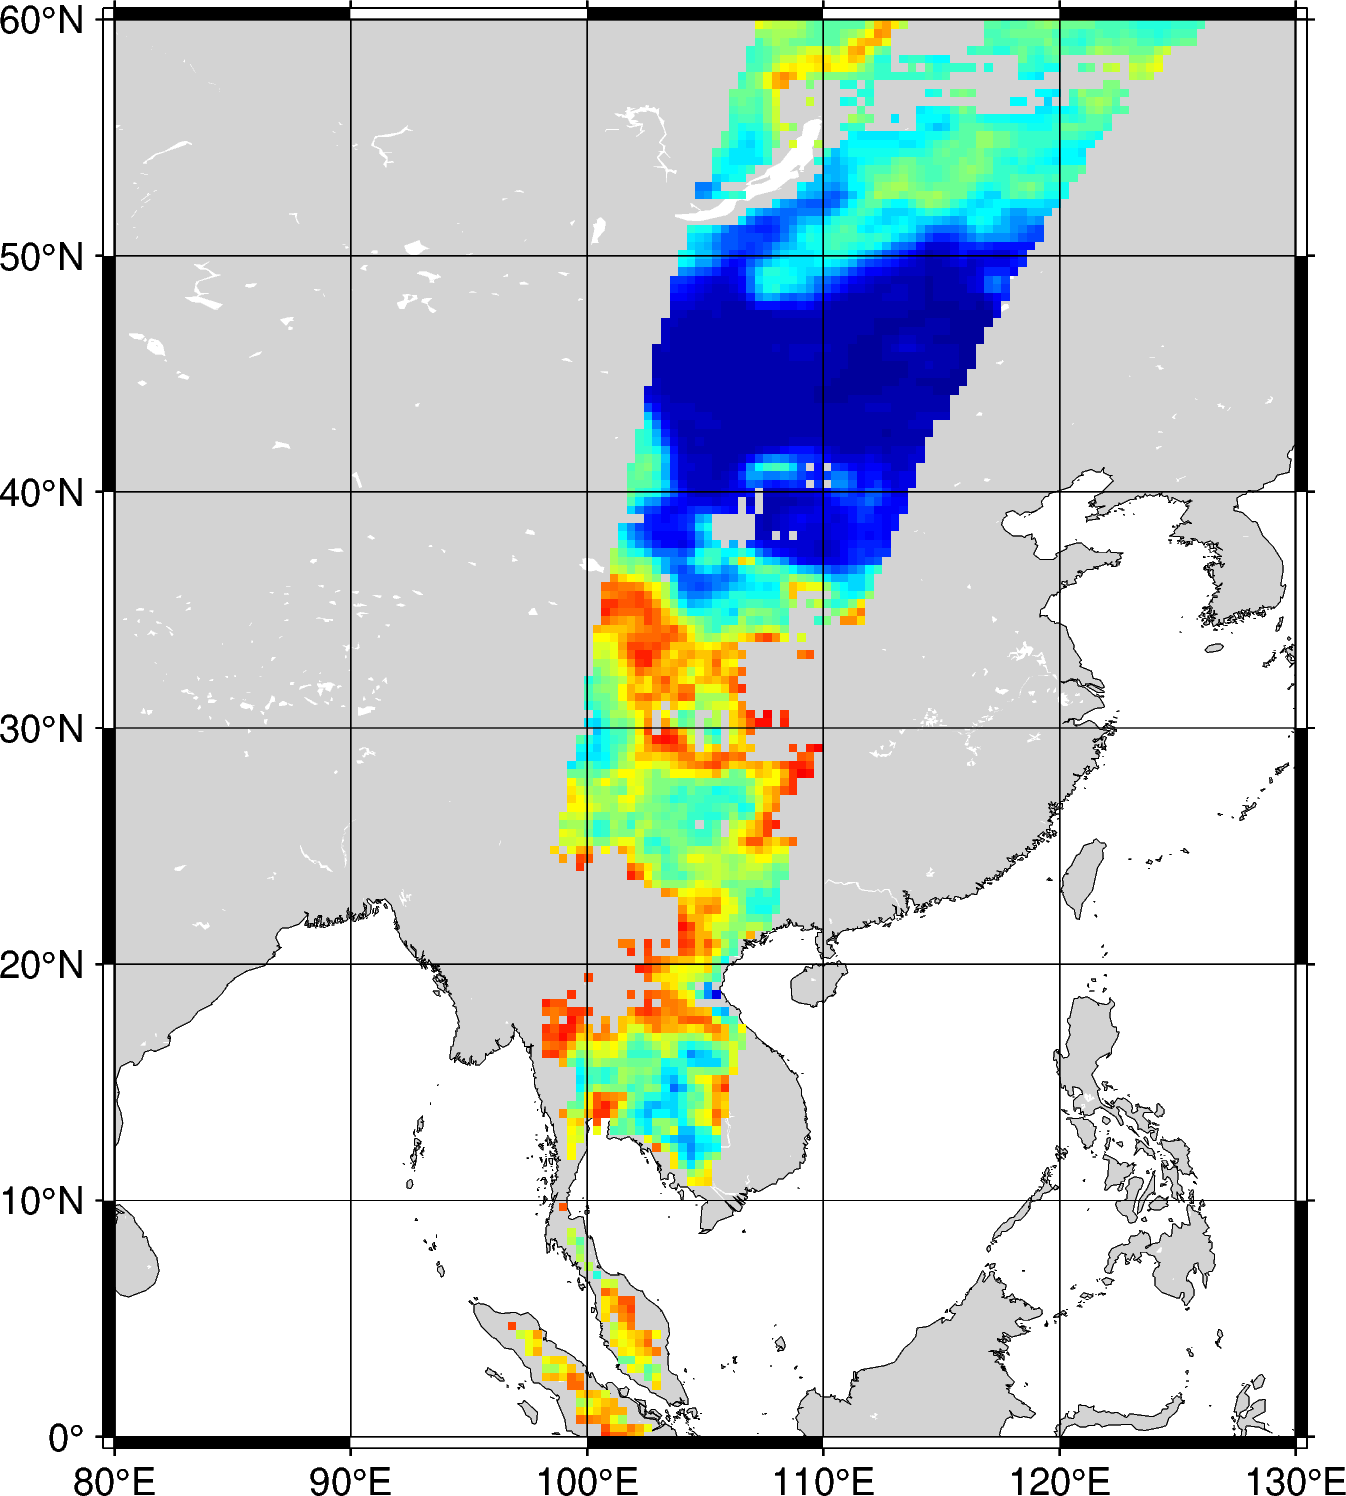

In [266]:
fig = pygmt.Figure()
pygmt.makecpt(cmap="jet", series="0/0.55/0.01")
fig.coast(region='80/130/0/60',projection="Q10c", land="lightgray", water="white", shorelines="1/0.1p")
fig.grdimage(grid_sm, cmap=True, nan_transparent=True, frame="ag")
fig.show()

## GDAL方案

In [ ]:
from osgeo import gdal



## scipy方案

## pyresample 方案

In [284]:
from pyresample.plot import show_quicklook
from pyresample.kd_tree import resample_nearest
from pyresample.geometry import SwathDefinition, create_area_def, GridDefinition

In [293]:
# 定义数据条带
swath = SwathDefinition(lons=ds["lon"], lats=ds["lat"])

# 定义目标区域
area = create_area_def(area_id="roi", 
                       resolution=0.36,
                       units="degrees", 
                       projection="+proj=longlat",
                       area_extent=(-180, -90, 180, 90))

grid_sm=resample_nearest(fill_value=np.nan,
                         target_geo_def=area, 
                         source_geo_def=swath,
                         data=ds["sm"].to_numpy(),
                         radius_of_influence=36000)

### 画出来瞧瞧

<IPython.core.display.Javascript object>


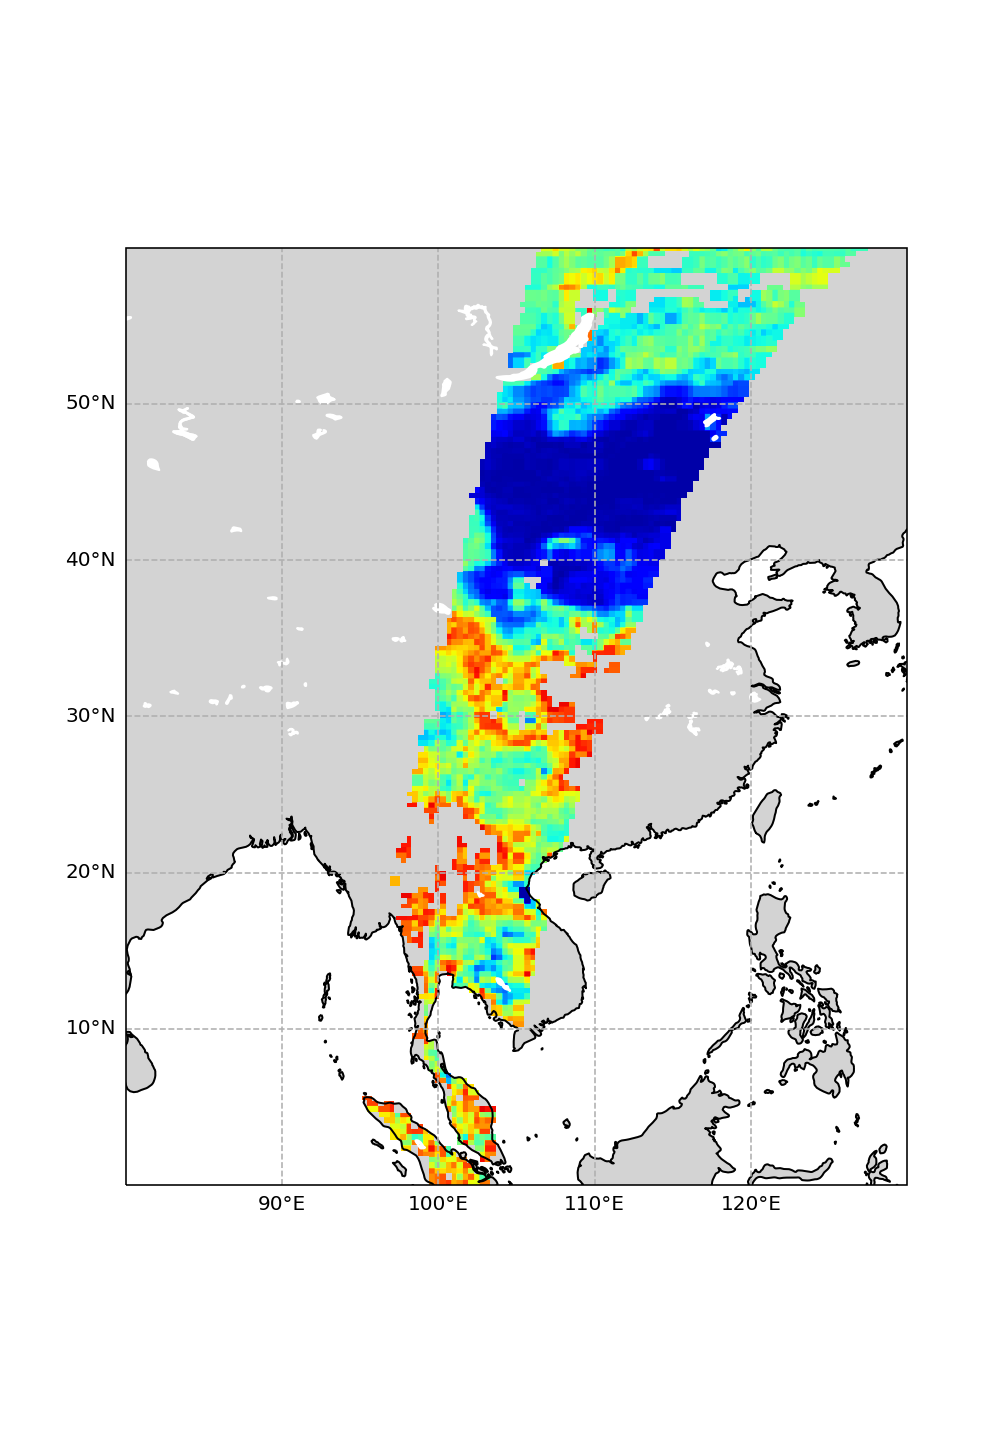

In [297]:
%matplotlib notebook
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(7,10))
map_crs = ccrs.PlateCarree()
data_crs = area.to_cartopy_crs()
ax = fig.add_subplot(1, 1, 1, projection=map_crs)
ax.set_extent(extents=[80, 130, 0, 60], crs=map_crs)
gridlines = ax.gridlines(linestyle="--", draw_labels=True)
gridlines.top_labels, gridlines.right_labels = None, None

ax.add_feature(cfeature.LAKES, facecolor="white")
ax.add_feature(cfeature.OCEAN, facecolor="white")
ax.add_feature(cfeature.LAND, facecolor="lightgray")

ax.imshow(grid_sm,transform=data_crs, extent=data_crs.bounds, origin='upper', vmin=0, vmax=0.55, cmap="jet")
ax.add_feature(cfeature.COASTLINE)

plt.show()

### 输出到tif

In [303]:
import rasterio

transform = rasterio.transform.from_bounds(*area.area_extent,area.shape[1],area.shape[0])
with rasterio.open(fp="grid_tif.tif",
                   mode="w",
                   driver="GTiff",
                   height=grid_sm.shape[0], 
                   width=grid_sm.shape[1],
                   count=1,
                   crs="+proj=longlat",
                   transform=transform,
                   dtype=grid_sm.dtype, 
                   nodata=np.nan) as output_tif:
    
    output_tif.write(grid_sm, 1)